In [13]:
import os
from tqdm.auto import tqdm
import re

import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timezone, timedelta
FIT_EPOCH_UTC = datetime(1989, 12, 31, tzinfo=timezone.utc)

import gpxpy
from garmin_fit_sdk import Decoder, Stream
import folium
import fiona
import shapely
from shapely.geometry import MultiLineString
from haversine import haversine
import calmap

import pickle
# m = folium.Map(location=(45.5236, -122.6750))

In [14]:
activity_colors={'running': '#fc4c02',
                 'cycling': '#00aa69',
                 'AlpineSki': '#c860df',
                 'NordicSki': '#eb3483',
                 'hiking': '#e6e227',
                 'IceSkate': '#68e8e8'}
                 #'swimming': '#0060f5'}

In [15]:
# Set data directory
directory = 'C:/Users/imehr/Documents/GitHub/activities/export_7971201/activities/'
os.chdir(path=directory)

def extract_numeric(filename):
    """Extract numeric value from filename for sorting."""
    numbers = re.findall(r'\d+', filename)
    return int(numbers[0]) if numbers else float('inf')

def factor_dimensions(total, max_diff=10):
    """Find optimal grid dimensions for subplot layout."""
    root = int(total**0.5)
    for i in range(root, 0, -1):
        if total % i == 0:
            rows, cols = i, total // i
            break
    else:
        rows, cols = 1, total

    if abs(rows - cols) <= max_diff:
        return rows, cols
    
    nearest_square_root = math.ceil(total**0.5)
    return nearest_square_root, nearest_square_root

def calculate_distance(points):
    """Calculate total distance from GPS points in miles."""
    total_distance = 0
    for i in range(1, len(points)):
        start = (points[i-1].latitude, points[i-1].longitude)
        end = (points[i].latitude, points[i].longitude)
        total_distance += haversine(start, end) * 0.621371
    return total_distance

def extract_date_distance(gpx):
    """Extract date and distance from GPX file."""
    first_point_time = gpx.tracks[0].segments[0].points[0].time
    gpx_date = first_point_time.date() if first_point_time else None
    
    gpx_points = gpx.tracks[0].segments[0].points
    total_distance = calculate_distance(gpx_points)
    
    return gpx_date, total_distance

In [16]:
# Incremental load/update of activities_df using existing summary
parquet_path = '../../activities.parquet'
pickle_path = '../../activities.pkl'
summary_csv_path = '../../activities_summary.csv'

sorted_files = sorted(os.listdir(directory), key=extract_numeric)
# Keep only supported filetypes
sorted_files = [f for f in sorted_files if f.lower().endswith(('.gpx', '.fit'))]

# Load existing full dataframe if present
existing_df = None
if os.path.exists(parquet_path):
    try:
        existing_df = pd.read_parquet(parquet_path)
    except Exception:
        try:
            existing_df = pd.read_parquet(parquet_path, engine='fastparquet')
        except Exception:
            existing_df = None
if existing_df is None and os.path.exists(pickle_path):
    try:
        existing_df = pd.read_pickle(pickle_path)
    except Exception:
        existing_df = None
if existing_df is not None and not existing_df.empty:
    existing_df['date'] = pd.to_datetime(existing_df['date'])

# Determine processed files from summary CSV if available, else from existing_df
if os.path.exists(summary_csv_path):
    try:
        summary_df = pd.read_csv(summary_csv_path)
        processed_files = set(summary_df['file'].astype(str))
    except Exception:
        processed_files = set(existing_df['file'].astype(str)) if existing_df is not None and not existing_df.empty else set()
else:
    processed_files = set(existing_df['file'].astype(str)) if existing_df is not None and not existing_df.empty else set()

new_files = [f for f in sorted_files if f not in processed_files]

# Process only new files
records = []
sample_step = 10
for file in tqdm(new_files, desc='Processing new activities'):
    if file.lower().endswith('.gpx'):
        with open(file) as f:
            gpx = gpxpy.parse(f)
        track = gpx.tracks[0]
        segment = track.segments[0]
        all_points = segment.points

        sampled_points = all_points[::sample_step]
        latlons = [(p.latitude, p.longitude) for p in sampled_points]
        elevations_list = [p.elevation for p in sampled_points]

        # activity time
        time_list = [p.time for p in sampled_points]
        # Calculate total time of the activity in minutes
        if time_list and time_list[0] is not None and time_list[-1] is not None:
            total_time_minutes = (time_list[-1] - time_list[0]).total_seconds() / 60.0
        else:
            total_time_minutes = 0.0

        # Cumulative distances in km
        cum_dist_km = [0.0]
        for j in range(1, len(sampled_points)):
            d = haversine(
                (sampled_points[j-1].latitude, sampled_points[j-1].longitude),
                (sampled_points[j].latitude, sampled_points[j].longitude)
            )
            cum_dist_km.append(cum_dist_km[-1] + d)

        activity_date, total_distance_miles = extract_date_distance(gpx)
        activity_type = track.type

        # Geometry via Fiona (best-effort)
        try:
            with fiona.open(file, 'r', layer='tracks') as records_iter:
                geoms = [shapely.geometry.shape(rec['geometry']) for rec in records_iter]
                geometry = geoms[0] if len(geoms) > 0 else None
        except Exception:
            geometry = None

    elif file.lower().endswith('.fit'):
        # Parse FIT with garmin_fit_sdk
        activity_date = None
        activity_type = None
        total_time_minutes = 0.0
        total_distance_miles = 0.0
        latlons = []
        elevations_list = []
        cum_dist_km = []
        geometry = None

        try:
            stream = Stream.from_file(file)
            decoder = Decoder(stream)
            messages, errors = decoder.read()

            # Derive local start datetime
            local_dt = None
            # Try activity messages first (often include local_timestamp)
            for act in messages.get('activity_mesgs', []):
                if 'local_timestamp' in act and act['local_timestamp'] is not None:
                    try:
                        # Convert from FIT epoch (1989-12-31 UTC) to UTC, then to local
                        lt = int(act['local_timestamp'])
                        utc_dt = FIT_EPOCH_UTC + timedelta(seconds=lt)
                        local_dt = utc_dt.astimezone()
                        break
                    except Exception:
                        local_dt = None
                if local_dt is None and 'timestamp' in act and act['timestamp'] is not None:
                    try:
                        ts = act['timestamp']
                        if getattr(ts, 'tzinfo', None) is None:
                            ts = ts.replace(tzinfo=timezone.utc)
                        local_dt = ts.astimezone()
                        break
                    except Exception:
                        local_dt = None

            # Fallback to session start_time if needed
            if local_dt is None:
                for sess in messages.get('session_mesgs', []):
                    if 'start_time' in sess and sess['start_time'] is not None:
                        try:
                            ts = sess['start_time']
                            if getattr(ts, 'tzinfo', None) is None:
                                ts = ts.replace(tzinfo=timezone.utc)
                            local_dt = ts.astimezone()
                            break
                        except Exception:
                            local_dt = None

            if activity_date is None and local_dt is not None:
                activity_date = pd.to_datetime(local_dt).date()

            # Extract sport/sub_sport and distance from session messages
            for sess in messages.get('session_mesgs', []):
                if activity_type is None:
                    if 'sub_sport' in sess and sess['sub_sport'] is not None:
                        activity_type = str(sess['sub_sport'])
                    elif 'sport' in sess and sess['sport'] is not None:
                        activity_type = str(sess['sport'])
                if 'total_distance' in sess and sess['total_distance'] is not None:
                    total_distance_miles = float(sess['total_distance']) / 1609.344
                if 'total_elapsed_time' in sess and sess['total_elapsed_time'] is not None:
                    total_time_minutes = float(sess['total_elapsed_time']) / 60.0
                else:
                    total_time_minutes = 0.0
        except Exception:
            pass

        if activity_date is None:
            # Fallback from file modified time
            activity_date = pd.to_datetime(os.path.getmtime(file), unit='s').date()
        if activity_type is None:
            activity_type = 'other'

    records.append({
        'file': file,
        'date': activity_date,
        'activity_type': activity_type,
        'total_time_minutes': total_time_minutes,
        'total_distance_miles': total_distance_miles,
        'points': latlons,
        'elevations': elevations_list,
        'distances_km': cum_dist_km,
        'geometry': geometry,
    })

new_df = pd.DataFrame.from_records(records)
if not new_df.empty:
    new_df['date'] = pd.to_datetime(new_df['date'])

# Merge with existing
if existing_df is not None and not existing_df.empty:
    activities_df = pd.concat([existing_df, new_df], ignore_index=True)
else:
    activities_df = new_df.copy() if not new_df.empty else pd.DataFrame(columns=['file','date','activity_type','total_time_minutes','total_distance_miles','points','elevations','distances_km','geometry'])

# Export updated dataframe and summary
if not activities_df.empty:
    try:
        activities_df.to_parquet(parquet_path, index=False)
    except Exception:
        try:
            activities_df.to_parquet(parquet_path, index=False, engine='fastparquet')
        except Exception:
            activities_df.to_pickle(pickle_path)

    summary_cols = ['file', 'date', 'activity_type', 'total_time_minutes', 'total_distance_miles', 'points', 'elevations']
    activities_df.to_csv(summary_csv_path, index=False, columns=summary_cols)

# sort by activity date
activities_df = activities_df.sort_values('date').reset_index(drop=True)

# Grid dimensions based on activities count
activities_with_gps = activities_df[activities_df['geometry'].notnull() & activities_df['geometry'].apply(lambda g: hasattr(g, 'geoms') and len(g.geoms) > 0)]
num_tracks = len(activities_with_gps)
dimensions = factor_dimensions(max(num_tracks, 1))
n_rows, n_cols = dimensions[0], dimensions[1]

Processing new activities: 0it [00:00, ?it/s]


In [17]:
### HEATMAP

m = folium.Map(tiles="Cartodb dark_matter")

for _, row in tqdm(activities_with_gps.iterrows(), total=len(activities_with_gps), desc="Creating Heatmap"):
    points = row['points']
    color = activity_colors.get(row['activity_type'], '#000000')
    if points and len(points) > 1:
        folium.PolyLine(points, color=color, opacity=0.5).add_to(m)

m.fit_bounds(m.get_bounds())
m.save('../../figures/heatmap.html')

Creating Heatmap: 100%|██████████| 321/321 [00:00<00:00, 382.99it/s]


In [ ]:
### TRACK GRID

multilines = [geom for geom in activities_with_gps['geometry'] if geom is not None]
print(f'Multilines Extraction Complete: {len(multilines)} Multilines')

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*0.67, n_rows*0.67))
axes = axes.flatten()

for i, multi_line in tqdm(list(enumerate(multilines)), desc="Plotting Tracks", total=len(multilines)):
    ax = axes[i]
    
    for line in multi_line.geoms:
        x, y = line.xy
        ax.plot(x, y, color='black', lw=0.75)
    
    # Set bounds with small padding
    minx, miny, maxx, maxy = multi_line.bounds
    ax.set_xlim(minx - 0.001, maxx + 0.001)
    ax.set_ylim(miny - 0.001, maxy + 0.001)
    
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines[:].set_visible(False)
       
# Hide unused subplots
for j in range(len(multilines), len(axes)):
    axes[j].axis('off')

plt.tight_layout(pad=0.1, w_pad=0.25, h_pad=0.1)
plt.savefig('../../figures/tracks.png', format='png', dpi=300, transparent=True)
plt.show()

Multilines Extraction Complete: 321 Multilines


Plotting Tracks: 100%|██████████| 321/321 [00:01<00:00, 279.67it/s]


Creating Elevation Overlay: 100%|██████████| 321/321 [00:01<00:00, 316.15it/s]


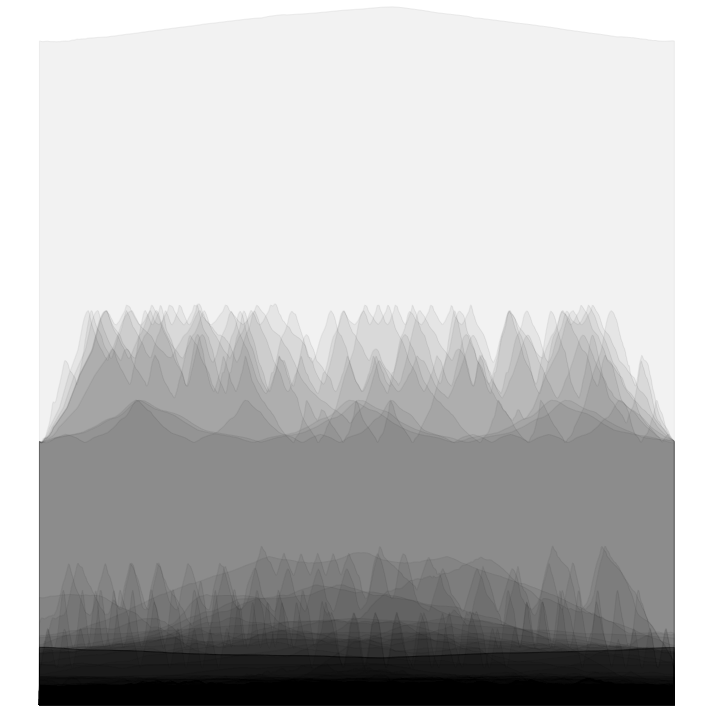

In [ ]:
### ELEVATION OVERLAY

num_points = 1000
x_values = np.linspace(0, 1, num_points)

max_elevation = activities_with_gps['elevations'].dropna().map(lambda arr: max(arr) if len(arr) else 0).max()

plt.figure(figsize=(10, 10))

for _, row in tqdm(activities_with_gps.iterrows(), total=len(activities_with_gps), desc="Creating Elevation Overlay"):
    distance = row['distances_km']
    elevation = row['elevations']
    if not distance or not elevation or len(distance) != len(elevation):
        continue
    scaled_distances = [d / distance[-1] if distance[-1] else 0 for d in distance]
    interpolated_elevations = np.interp(x_values, scaled_distances, elevation)

    plt.plot(x_values, interpolated_elevations, color='black', linestyle='-', linewidth=0.1, alpha=0.1)
    plt.fill_between(x_values, 0, interpolated_elevations, color='black', alpha=0.05)

plt.ylim(0, max_elevation)
plt.grid(False)
plt.xticks([])
plt.yticks([])
for spine in plt.gca().spines.values():
    spine.set_visible(False)

plt.tight_layout()
plt.savefig('../../figures/elevation_overlay.png', format='png', dpi=300, transparent=True)
plt.show()

Creating Elevation Grid: 100%|██████████| 321/321 [00:17<00:00, 18.77it/s]


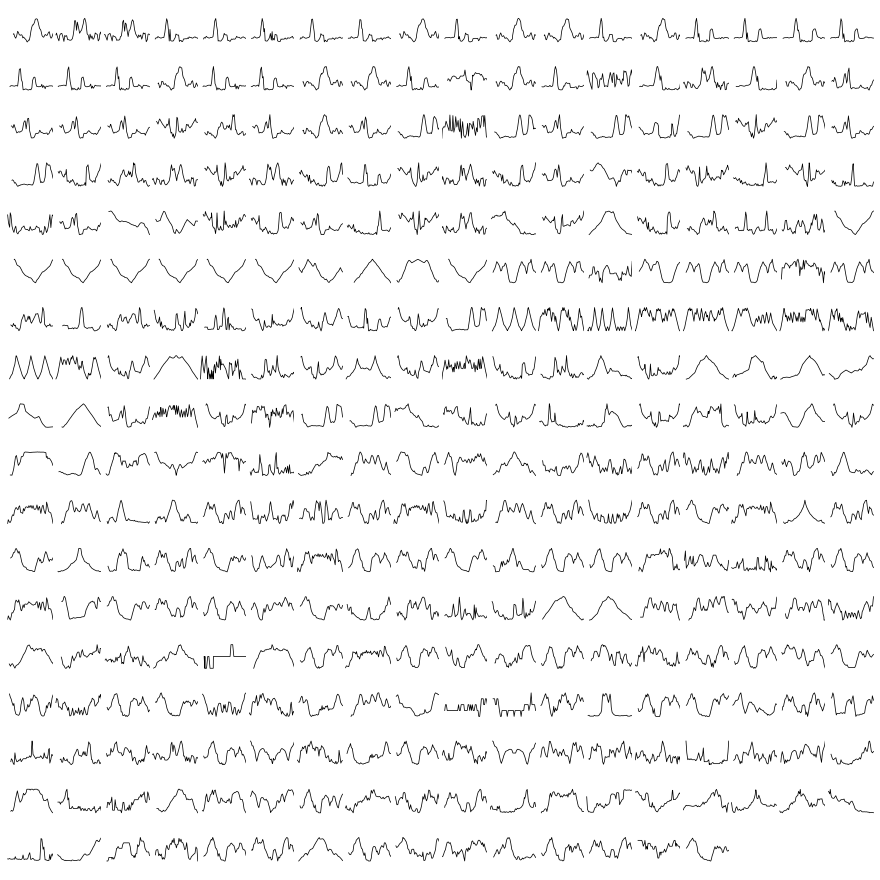

In [ ]:
### ELEVATION GRID

max_points = 50

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*0.67, n_rows*0.67))
axes = axes.flatten()

for i, (_, row) in tqdm(list(enumerate(activities_with_gps.iterrows())), total=len(activities_with_gps), desc="Creating Elevation Grid"):
    ax = axes[i]
    
    distance = row['distances_km']
    elevation = row['elevations']
    if not distance or not elevation:
        ax.axis('off')
        continue
    
    norm_elevations = [(elev - min(elevation)) / (max(elevation) - min(elevation)) if (max(elevation) - min(elevation)) else 0 for elev in elevation]
    
    if len(distance) > max_points:
        indices = np.linspace(0, len(distance) - 1, max_points).astype(int)
        distance = [distance[idx] for idx in indices]
        norm_elevations = [norm_elevations[idx] for idx in indices]
    
    ax.plot(distance, norm_elevations, color='black', lw=0.75)
        
    ax.set_xlim(-0.5, distance[-1])
    ax.set_ylim(-0.5, 1.5)
    
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines[:].set_visible(False)

# Hide unused subplots
for j in range(len(activities_with_gps), len(axes)):
    axes[j].axis('off')

plt.tight_layout(pad=0.1, w_pad=0.25, h_pad=0.1)
plt.savefig('../../figures/elevation_grid.png', format='png', dpi=300, transparent=True)
plt.show()

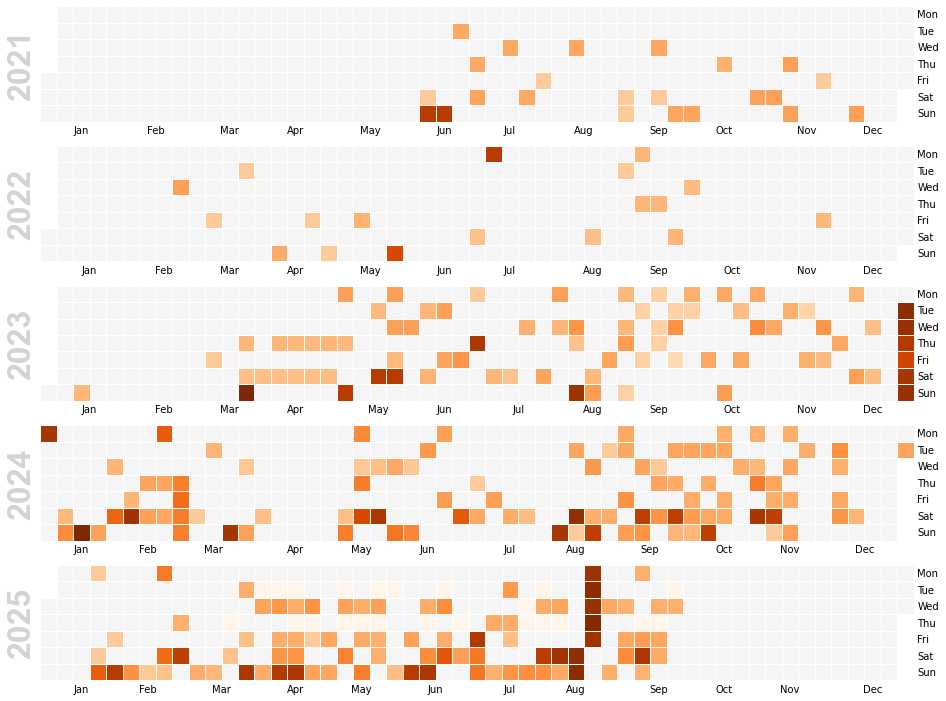

In [ ]:
### ACTIVITY CALENDAR

date_distance_series = activities_df.groupby('date')['total_distance_miles'].sum().sort_index()

calendar = calmap.calendarplot(
    np.log1p(date_distance_series), 
    cmap=plt.cm.Oranges, 
    fig_kws=dict(figsize=(20, 10)), 
    yearlabel_kws={'color': 'lightgray'}
)
calendar[0].savefig('../../figures/activity_calendar.png', format='png', dpi=300, transparent=True)

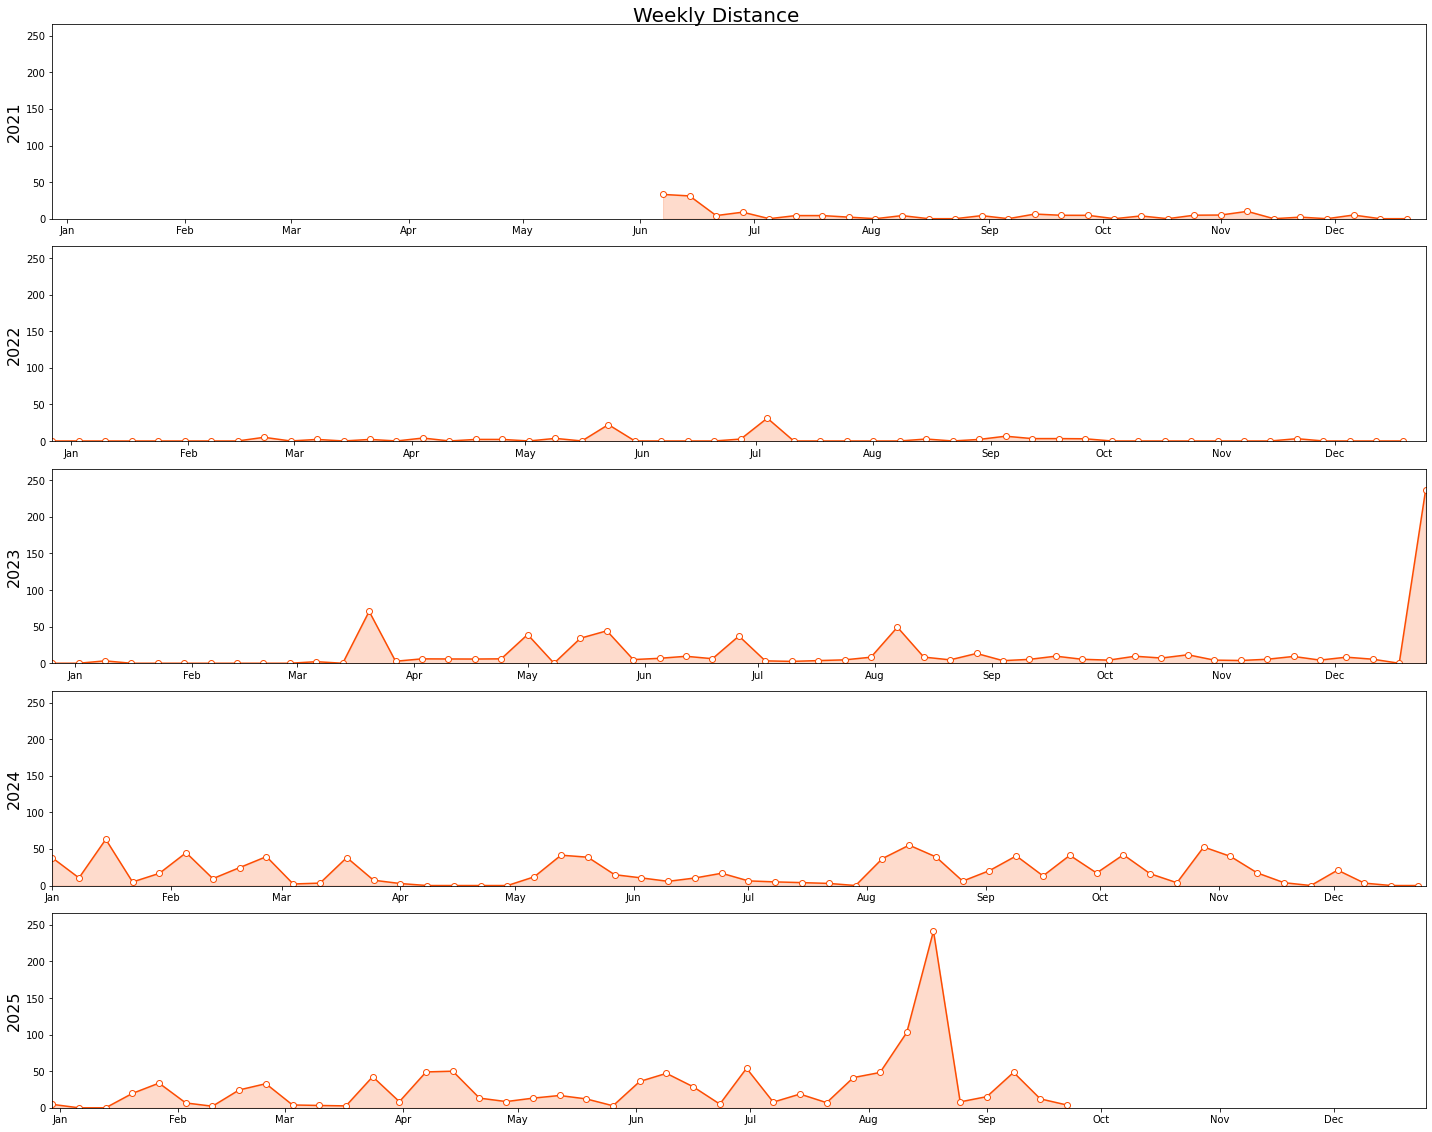

In [ ]:
### WEEKLY MILES

weekly_data = activities_with_gps.set_index('date')['total_distance_miles'].resample('W').sum()
years = weekly_data.index.year.unique()
fig, axes = plt.subplots(nrows=len(years), ncols=1, figsize=(20, 16), sharey=True)

for i, year in enumerate(years):
    ax = axes[i]
    full_year_range = pd.date_range(start=f'{year}-01-01', end=f'{year}-12-31', freq='W-SUN')
    year_data = weekly_data[weekly_data.index.year == year].reindex(full_year_range)
    
    ax.plot(year_data.index, year_data.values, color='#fc4c02', marker='o', markerfacecolor='white', label=f"{year}")
    ax.fill_between(year_data.index, 0, year_data.values, where=~year_data.isna(), color='#fc4c02', alpha=0.2)
    
    ax.set_xlim(pd.Timestamp(min(year_data.index)), pd.Timestamp(f'{year}-12-31'))
    ax.set_ylim(0, max(weekly_data.values) * 1.1)
    ax.set_ylabel(year, fontsize=16)
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=7))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

plt.suptitle('Weekly Distance', fontsize=20)
plt.tight_layout()
plt.savefig('../../figures/weekly_distance.png', format='png', dpi=100, transparent=True)
plt.show()

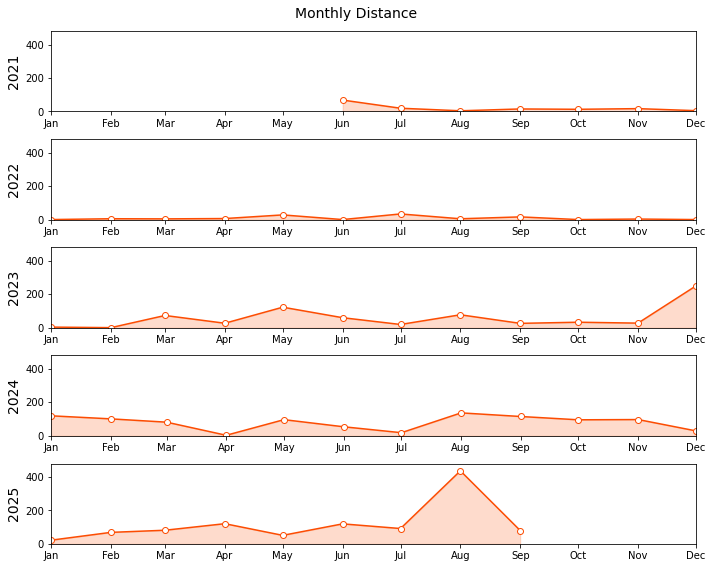

In [ ]:
### MONTHLY MILES

monthly_data = activities_with_gps.set_index('date')['total_distance_miles'].resample('M').sum()
years = monthly_data.index.year.unique()
fig, axes = plt.subplots(nrows=len(years), ncols=1, figsize=(10, 8), sharey=True)

for i, year in enumerate(years):
    ax = axes[i]
    year_data = monthly_data[monthly_data.index.year == year]
    year_data.index = year_data.index.to_period('M').to_timestamp()
    
    ax.plot(year_data.index, year_data.values, color='#fc4c02', label=f"{year}", marker='o', markerfacecolor='white')
    ax.fill_between(year_data.index, 0, year_data.values, color='#fc4c02', alpha=0.2)
    
    ax.set_xlim(pd.Timestamp(f'{year}-01-01'), pd.Timestamp(f'{year}-12-01'))
    ax.set_ylim(0, max(monthly_data.values) * 1.1)
    ax.set_ylabel(year, fontsize=14)
    
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

plt.suptitle('Monthly Distance', fontsize=14)
plt.tight_layout()
plt.savefig('../../figures/monthly_distance.png', format='png', dpi=100, transparent=True)
plt.show()

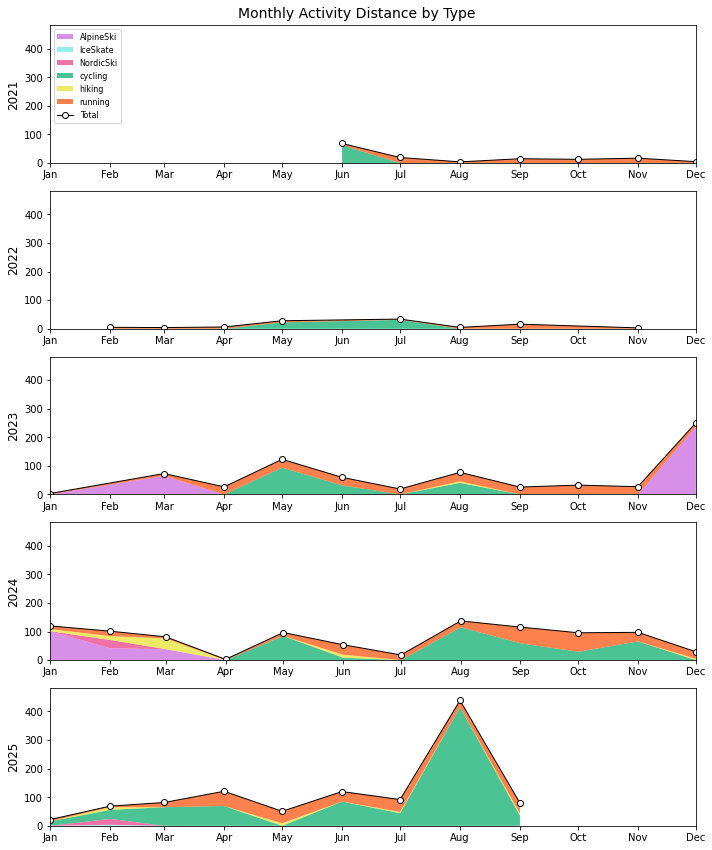

In [ ]:
### MONTHLY MILE TYPE

monthly_data = activities_with_gps.groupby(['activity_type', pd.Grouper(key='date', freq='M')])['total_distance_miles'].sum()
monthly_data = monthly_data.reset_index()
monthly_pivot = monthly_data.pivot_table(index='date', columns='activity_type', values='total_distance_miles', fill_value=0)

years = monthly_pivot.index.year.unique()
fig, axes = plt.subplots(nrows=len(years), ncols=1, figsize=(10, 12), sharey=True)

for i, year in enumerate(years):
    ax = axes[i]
    year_data = monthly_pivot[monthly_pivot.index.year == year]
    year_data.index = year_data.index.to_period('M').to_timestamp()
    
    activities = year_data.columns
    month_indexes = year_data.index
    stacked_distances = [year_data[activity].values for activity in activities]
    activity_colors_list = [activity_colors.get(activity, '#000000') for activity in activities]
    
    ax.stackplot(month_indexes, stacked_distances, labels=activities, colors=activity_colors_list, alpha=0.7)
    
    total_distance = year_data.sum(axis=1)
    ax.plot(month_indexes, total_distance, color='black', marker='o', markerfacecolor='white', lw=1, label="Total")
    
    ax.set_xlim(pd.Timestamp(f'{year}-01-01'), pd.Timestamp(f'{year}-12-01'))
    ax.set_ylim(0, max(monthly_pivot.sum(axis=1)) * 1.1)
    ax.set_ylabel(year, fontsize=12)
    
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

    if i == 0:
        ax.legend(loc='upper left', fontsize=8)

plt.suptitle('Monthly Activity Distance by Type', fontsize=14)
plt.tight_layout()
plt.savefig('../../figures/monthly_distance_split.png', format='png', dpi=100, transparent=True)
plt.show()